# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

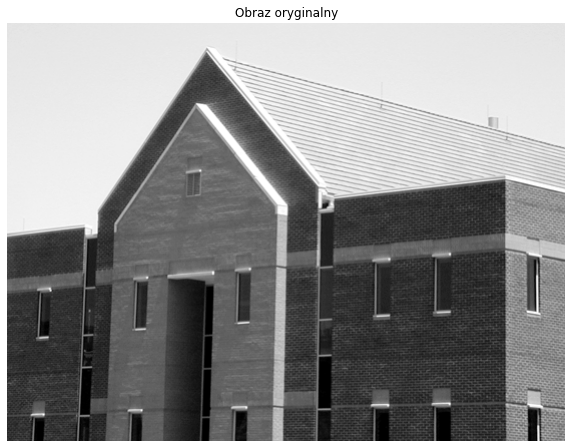

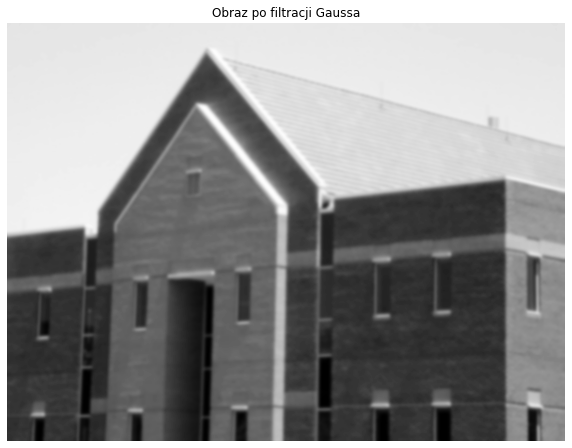

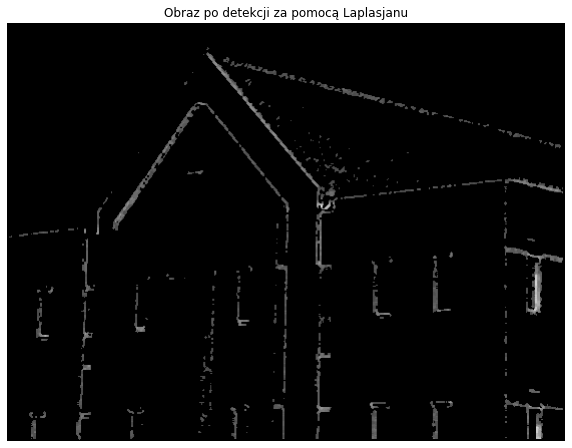

In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate
dom = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dom, 'gray', vmin=0, vmax=256)
ax.axis('off')
ax.set_title('Obraz oryginalny')
plt.show()

dom_gauss = cv2.GaussianBlur(dom,(15,15),1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dom_gauss, 'gray', vmin=0, vmax=256)
ax.axis('off')
ax.set_title('Obraz po filtracji Gaussa')
plt.show()

laplacian = cv2.Laplacian(dom_gauss,cv2.CV_32F)

def crossing(LoG, thr):
    X, Y = LoG.shape
    table = np.zeros((X,Y))
    for i in range(1, X - 1):
        for j in range (1, Y - 1):
            surrounding = LoG[i - 1: i + 2, j - 1: j + 2]
            max = np.max(surrounding)
            min = np.min(surrounding)
            if min * max < 0:
                if LoG[i][j] > 0:
                    table[i][j] = LoG[i][j] + np.abs(min)
                if LoG[i][j] < 0:
                    table[i][j] = np.abs(LoG[i][j]) + max
    table = (table/np.max(table)) * 255
    table = (table > thr) * table
    table = table.astype('uint8')
    table = cv2.medianBlur(table, 3)
    return table

result = crossing(laplacian, 69)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(result, 'gray', vmin=0, vmax=256)
ax.axis('off')
ax.set_title('Obraz po detekcji za pomocą Laplasjanu')
plt.show()

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

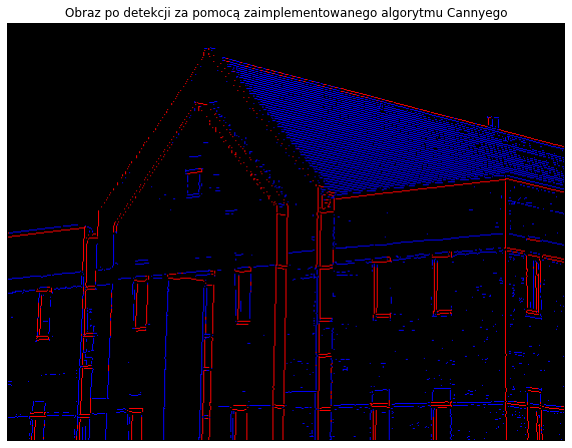

In [6]:
def nonmax(direction_table, M):
    X, Y = direction_table.shape
    gn = np.zeros((X,Y))
    for i in range(1, X - 1):
        for j in range(1, Y - 1):
            if direction_table[i][j] == 'd1':
                if M[i + 1][j] > M[i][j] or M[i - 1][j] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
            elif direction_table[i][j] == 'd2':
                if M[i][j + 1] > M[i][j] or M[i][j - 1] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
            elif direction_table[i][j] == 'd3':
                if M[i - 1][j - 1] > M[i][j] or M[i + 1][j + 1] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
            elif direction_table[i][j] == 'd4':
                if M[i - 1][j + 1] > M[i][j] or M[i + 1][j - 1] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
    return gn

def canny(image, Tl, Th):
    X, Y = image.shape
    image_gauss = cv2.GaussianBlur(image,(3,3),1.5)
    gx = cv2.Sobel(image_gauss, cv2.CV_64F,1,0,ksize=3)
    gy = cv2.Sobel(image_gauss, cv2.CV_64F,0,1,ksize=3)
    M = np.sqrt(np.power(gx,2) + np.power(gy,2))
    alpha = np.arctan2(gy,gx) * 180 / np.pi
    direction_table = np.full((X,Y),'aa')
    for i in range(X):
        for j in range(Y):
            if  67.5 <= alpha[i][j] <= 112.5 or -112.5 <= alpha[i][j] <= -67.5:
                direction_table[i][j] = 'd1'
            elif -22.5 <= alpha[i][j] <= 22.5 or alpha[i][j] >= 157.5 or alpha[i][j] <= -157.5:
                direction_table[i][j] = 'd2'
            elif 112.5 <= alpha[i][j] <= 157.5 or -67.5 <= alpha[i][j] <= -22.5:
                direction_table[i][j] = 'd3'
            elif 22.5 <= alpha[i][j] <= 67.5 or -157.5 <= alpha[i][j] <= -112.5:
                direction_table[i][j] = 'd4'
    gn = nonmax(direction_table, M)
    gnh = gn >= Th
    gnl = (gn >= Tl) * (gn < Th)
    return gnh, gnl

gnh, gnl = canny(dom, 55, 165)
X, Y = dom.shape
result1 = np.zeros((X,Y,3))
for i in range(X):
    for j in range(Y):
        if gnh[i][j]:
            result1[i][j] = [255, 0, 0]
        if gnl[i][j]:
            result1[i][j] = [0, 0, 255]
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(result1.astype('uint8'))
ax.axis('off')
ax.set_title('Obraz po detekcji za pomocą zaimplementowanego algorytmu Cannyego')
plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

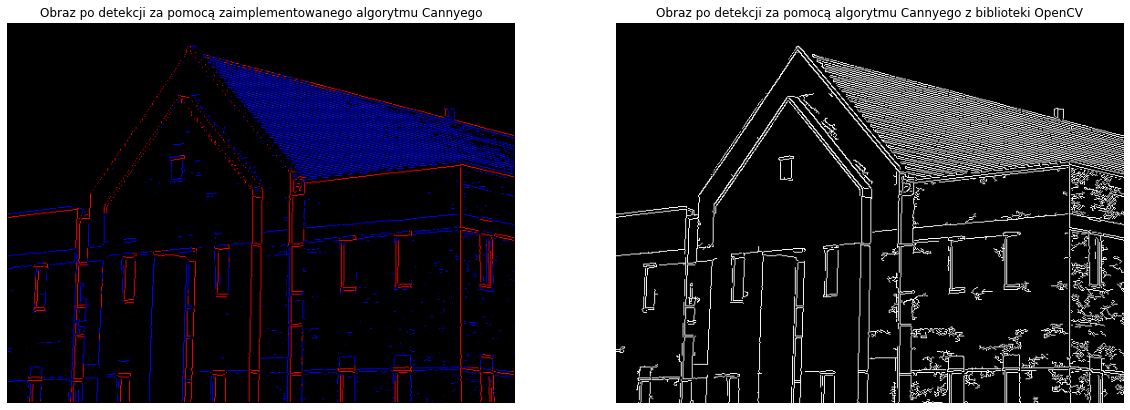

In [7]:
# Największą różnicą jest fakt, że obraz po detekcji za pomocą algorytmu z biblioteki OpenCV jest pozbawiony szumów. Drugą widoczną różnicą jest to, że funkcja biblioteczna lepiej radzi sobie z zachowaniem prawidłowego kształtu krawędzi -> krawędzie nie są aż tak poprzerywane, jak w funkcji zaimplementowanej samodzielnie.

result2 = cv2.Canny(dom, 55, 165, None, 3, 1)
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(result1.astype('uint8'), 'gray')
ax[0].axis('off')
ax[0].set_title('Obraz po detekcji za pomocą zaimplementowanego algorytmu Cannyego')
ax[1].imshow(result2, 'gray')
ax[1].axis('off')
ax[1].set_title('Obraz po detekcji za pomocą algorytmu Cannyego z biblioteki OpenCV')
plt.show()